![brain_baner](http://www.mf-data-science.fr/images/projects/brain_baner.jpg)

**This Notebook is the extension of the tests of a CNN 3D model on all MRI types developed in a first Notebook *(with EDA)* :**

<span style="font-size:18px">[🧠Brain Tumor 3D Multimodal CNN - All MRI Type](https://www.kaggle.com/michaelfumery/brain-tumor-3d-multimodal-cnn-all-mri-type/)</span>

<h1 style="color:#0b0a2d; font-size:24px; text-transform: uppercase; font-weight:bold">Context</h1>

The goal of this competition, initiated by the **Radiological Society of North America *(RSNA)*** in partnership with the **Medical Image Computing and Computer Assisted Intervention Society *(the MICCAI Society)*** is to predict the methylation of the **MGMT promoter**, which is an important gene biomarker for treatment of brain tumors.

These predictions will be based on a database of **MRI *(magnetic resonance imaging)*** scans of several hundred patients.

<h1 style="color:#0b0a2d; font-size:24px; text-transform: uppercase; font-weight:bold">Data</h1>

Each independent case has a dedicated folder identified by a five-digit number. Within each of these “case” folders, there are four sub-folders, each of them corresponding to each of the structural multi-parametric MRI (mpMRI) scans, in DICOM format. The exact mpMRI scans included are:

- Fluid Attenuated Inversion Recovery (FLAIR)
- T1-weighted pre-contrast (T1w)
- T1-weighted post-contrast (T1Gd)
- T2-weighted (T2)

| ![brain_baner](http://www.mf-data-science.fr/images/projects/brain_tumor_types.png) | 
|:--:| 
| *Examples of the four MR sequence types included in this work* |

<h1 style="color:#0b0a2d; font-size:24px; text-transform: uppercase; font-weight:bold">Acknowledgement</h1>

This Notebook is inspired from *Ammar Alhaj Ali* work :
- [🧠Brain Tumor 3D [Training]](https://www.kaggle.com/ammarnassanalhajali/brain-tumor-3d-training)
- [🧠Brain Tumor 3D [Inference]](https://www.kaggle.com/ammarnassanalhajali/brain-tumor-3d-inference)

<h1 style="color:#0b0a2d; font-size:24px; text-transform: uppercase; font-weight:bold">Sommaire</h1>

1. [Load data](#section_1)      
2. [Image preprocessing](#section_2)      
3. [Load pre-trained ResNet50 model](#section_3)      
4. [Create a matrix of vectors base on ResNet50 for each patient sequence](#section_4)     
5. [Apply LSTM for classification with Kfold](#section_5)      
6. [Predict on test set with best model](#section_6)

First, we have to load the usefull Python libraries :

In [1]:
import os
import glob
import re
import math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# <span style="color:#0b0a2d; font-size:24px; text-transform: uppercase; font-weight:bold" id="section_1">Load data</span>

We will first load the anotated training data files:

In [2]:
data_directory = './'

In [3]:
train_df = pd.read_csv(data_directory+"train_labels.csv")
train_df['BraTS21ID5'] = [format(x, '05d') for x in train_df.BraTS21ID]
train_df.head(3)

,BraTS21ID,MGMT_value,BraTS21ID5
0,0,1,00000
1,2,1,00002
2,3,0,00003


and the test data :

In [4]:
test = pd.read_csv(
    data_directory+'sample_submission.csv')

test['BraTS21ID5'] = [format(x, '05d') for x in test.BraTS21ID]
test.head(3)

,BraTS21ID,MGMT_value,BraTS21ID5
0,17,0.5,00017
1,20,0.5,00020
2,28,0.5,00028


# <span style="color:#0b0a2d; font-size:24px; text-transform: uppercase; font-weight:bold" id="section_2">Image preprocessing</span>

For each patient, we will carry out a pre-processing of the images by applying these different modifications:
- Load an ordered sequence of 64 MRI scan
- Crop images to reduce black borders
- Resize image for pre-train model
- Apply denoising filter
- Convert each image in **3D array**

In [5]:
IMAGE_SIZE = 240
SCALE = .8
NUM_IMAGES = 64
MRI_TYPE = "FLAIR"

## <span style="color:#3c99dc; font-size:18px; text-transform: uppercase; font-weight:bold" id="section_1_1">Load single image</span>

In [6]:
def load_dicom_image(
    path,
    img_size=IMAGE_SIZE,
    scale=SCALE):
    '''
    This function allows you to load a DCIM type image 
    and apply preprocessing steps such as crop, resize 
    and denoising filter to it.
    ****************************************************
    PARAMETERS
    ****************************************************
    - path : String
        Path to the DCIM image file to load.
    - img_size : Integer
        Image size desired for resizing.
    - scale : Float
        Desired scale for the cropped image
    - prep : Bool
        True for a full preprocessing with
        denoising.
    '''
    # Load single image
    img = dicom.read_file(path).pixel_array
    # Crop image
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    # Resize image
    img = cv2.resize(img, (img_size, img_size))
    
    # Convert in 3D array
    img = np.repeat(img[..., np.newaxis], 3, -1)
    
    return img

We can check the result of these different preprocessing steps on a random patient:

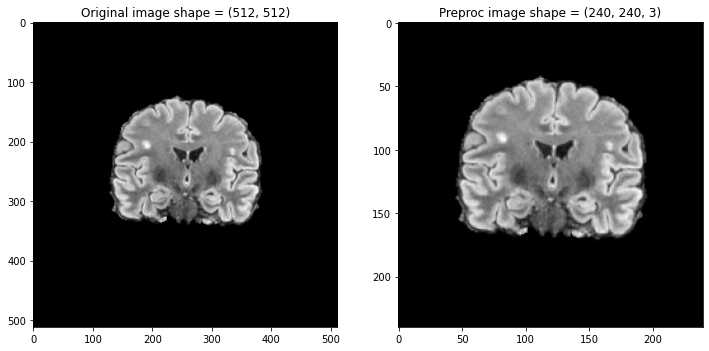

In [7]:
sample_img = dicom.read_file(
    data_directory+"train/00046/FLAIR/Image-90.dcm").pixel_array
preproc_img = load_dicom_image(data_directory+"train/00046/FLAIR/Image-90.dcm")


fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(1,2,1)
ax1.imshow(sample_img, cmap="gray")
ax1.set_title(f"Original image shape = {sample_img.shape}")
ax2 = plt.subplot(1,2,2)
ax2.imshow(preproc_img[:,:,0], cmap="gray")
ax2.set_title(f"Preproc image shape = {preproc_img.shape}")
plt.show()

## <span style="color:#3c99dc; font-size:18px; text-transform: uppercase; font-weight:bold" id="section_1_2">Load sequence of 64 preprocessed images</span>

As we saw **in the EDA part of the previous [Notebook](https://www.kaggle.com/michaelfumery/brain-tumor-3d-multimodal-cnn-all-mri-type)**, we are going to load the image sequence starting from the central image in order to avoid completely black images. We will then take the same number of images on each side of this central image.

In [8]:
def load_dicom_images_3d(
    scan_id, 
    num_imgs=NUM_IMAGES, 
    img_size=IMAGE_SIZE, 
    mri_type=MRI_TYPE, 
    split="train"):
    '''
    This function allows loading an ordered sequence 
    of x preprocessed images starting from the central 
    image of each folder.
    ****************************************************
    PARAMETERS
    ****************************************************
    - scan_id : String
        ID of the patient to load.
    - num_imgs : Integer
        Number of desired images of the 
        sequence.
    - img_size : Integer
        Image size desired for resizing.
    - scale : Float
        Desired scale for the cropped image
    - mri_type : String
        Type of scan to load (FLAIR, T1w, 
        T1wCE, T2).
    - split : String
        Type of split desired : Train or Test
    '''
    files = sorted(glob.glob(f"{data_directory}{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f) for f in files[p1:p2]]) 
    if img3d.shape[0] < num_imgs:
        n_zero = np.zeros((num_imgs - img3d.shape[0], img_size, img_size, 3))
        img3d = np.concatenate((img3d,  n_zero), axis = 0)
            
    return img3d

Here again we can test the loading of a sequence of preprocessed images for a patient:

Shape of the sequence is: (64, 240, 240, 3)
Dimension of the 15th image in sequence is: (240, 240, 3)


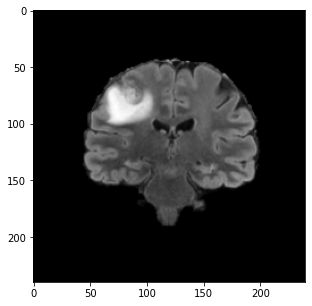

In [9]:
sample_seq = load_dicom_images_3d("00046")
print("Shape of the sequence is:", sample_seq.shape)
print("Dimension of the 15th image in sequence is:", sample_seq[15].shape)
fig = plt.figure(figsize=(5,5))
plt.imshow(np.squeeze(sample_seq[15][:,:,0]), cmap="gray")
plt.show()

# <span style="color:#0b0a2d; font-size:24px; text-transform: uppercase; font-weight:bold" id="section_3">Load pre-trained ResNet50 model</span>

To carry out the Transfer Learning on each image of the sequence, we will load a pre-trained model thanks to `Keras.applications` with the pre-trained weights on **ImageNet**.      
As the notebook must be without Internet for the competition, the weights are loaded separately and imported from a specially created Dataset *(../input/resnet-imagenet-weights)*.

Here we will chrger the **ResNet50 model**, knowing that other models have been tested such as ResNet50 and Xception.

In [10]:
base_resnet = keras.applications.ResNet50(
    weights=None,
    #weights="imagenet",
    pooling='avg',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False)

"""base_resnet.save_weights(
    'base_resnet_imagenet.h5')"""
base_resnet.load_weights(
    './checkpoint/base_resnet_imagenet.h5')

We are also going to **fix all the layers of the model** so that they are not re-trained for the detection of features. The classification layer is also not loaded (`include_top = False`).

In [11]:
base_resnet.trainable = False

# <span style="color:#0b0a2d; font-size:24px; text-transform: uppercase; font-weight:bold" id="section_4">Create a matrix of vectors base on ResNet50 for each patient sequence</span>

For this part of Transfer Learning, we will not train the ResNet50 model but only perform the prediction for each image of the sequence of each patient.     
We will thus obtain, for each image, a matrix of the model weights that we will integrate into a list to recreate the patient sequence.     
Finally, we are going to create a global matrix which will group together the sequences of x ResNet50.predict matrices for all the patients.

Let's look at the pseudo-code:
```Python
# Transfert Learning
listMatrix = []
for person in persons:
    listVectors = []
    for image in person.images:
        img = preprocess(image)
        vector = baseModel.predict(img)
        listVectors.append(vector)

    PatientMatrix = np.stack(listVectors)
    listMatrix.append(PatientMatrix)
```

In [12]:
train = train_df[['BraTS21ID5','MGMT_value']]
X_train = train['BraTS21ID5'].values
y_train = train['MGMT_value'].values

**We will apply this process for just one type of MRI scans (here is T1w type)** for each patient. Each patient will therefore have 24 images for treatment.

In [13]:
listMatrix = []
for i, patient in enumerate(tqdm(X_train)):
    listVectors = []
    sequence = load_dicom_images_3d(scan_id=str(patient),mri_type=MRI_TYPE)
    for j in range(len(sequence)):
        img = sequence[j]
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.resnet50.preprocess_input(img)
        img_vector = base_resnet.predict(img)
        listVectors.append(np.array(img_vector))
    
    PatientMatrix = np.stack(listVectors)
    listMatrix.append(PatientMatrix)

  0%|          | 0/509 [00:00<?, ?it/s]

Let us now look at the shapes of the matrices obtained following the application of this Learning Transfer:

In [14]:
print(f"Number of patient matrix: {len(listMatrix)}")
print(f"Patient matrix shape: {listMatrix[0].shape}")

Number of patient matrix: 509
Patient matrix shape: (64, 1, 2048)


In [15]:
np.array(listMatrix, dtype=object).shape

(509, 64, 1, 2048)

# <span style="color:#0b0a2d; font-size:24px; text-transform: uppercase; font-weight:bold" id="section_5">Apply LSTM for classification</span>

Recurrent neural networks (RNNs) are widely used in artificial intelligence when a temporal notion is involved in the data.

LSTM is a complex and very powerful algorithm which will allow in our case to take into account the past elements of our sequence of images.

In [16]:
model_input_dim = listMatrix[0].shape[2]

In [17]:
def get_sequence_model():
    '''Define the LSTM architecture'''
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(100, input_shape=(NUM_IMAGES, model_input_dim), return_sequences=True))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

In [18]:
from sklearn.model_selection import KFold

inputs = np.array(listMatrix)
targets = np.array(y_train).astype('float32').reshape((-1,1))

num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
history = {}
fold_no = 1
for train_df, valid_df in kfold.split(inputs, targets):
    
    train_dataset = tf.data.Dataset.from_tensor_slices((inputs[train_df], targets[train_df]))
    valid_dataset = tf.data.Dataset.from_tensor_slices((inputs[valid_df], targets[valid_df]))
    
    model = get_sequence_model()
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics='accuracy')
    
    # Define callbacks.
    model_save = ModelCheckpoint(f'Brain_lstm_kfold_{fold_no}.h5', 
                                 save_best_only = True, 
                                 monitor = 'val_accuracy', 
                                 mode = 'max', verbose = 1)
    early_stop = EarlyStopping(monitor = 'val_accuracy', 
                               patience = 25, mode = 'max', verbose = 1,
                               restore_best_weights = True)
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    epochs = 200
    history[fold_no] = model.fit(
        train_dataset,
        validation_data=valid_dataset, 
        epochs=epochs, 
        batch_size=32,
        callbacks = [model_save, early_stop])
    
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/200
401/407 [============================>.] - ETA: 0s - loss: 0.7114 - accuracy: 0.5192WARNING:tensorflow:Model was constructed with shape (None, 64, 2048) for input Tensor("lstm_input:0", shape=(None, 64, 2048), dtype=float32), but it was called on an input with incompatible shape (64, 1, 2048).

Epoch 00001: val_accuracy improved from -inf to 0.62730, saving model to Brain_lstm_kfold_1.h5
407/407 [==============================] - 2s 6ms/step - loss: 0.7112 - accuracy: 0.5194 - val_loss: 0.6678 - val_accuracy: 0.6273
Epoch 2/200
407/407 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.5360
Epoch 00002: val_accuracy did not improve from 0.62730
407/407 [==============================] - 2s 4ms/step - loss: 0.6964 - accuracy: 0.5360 - val_loss: 0.6730 - val_accuracy: 0.6077
Epoch 3/200
398/407 [============================>.] - ETA: 0s - loss: 0.6942 - accura

Epoch 00026: early stopping
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/200
402/407 [============================>.] - ETA: 0s - loss: 0.6994 - accuracy: 0.5512WARNING:tensorflow:Model was constructed with shape (None, 64, 2048) for input Tensor("lstm_1_input:0", shape=(None, 64, 2048), dtype=float32), but it was called on an input with incompatible shape (64, 1, 2048).

Epoch 00001: val_accuracy improved from -inf to 0.55607, saving model to Brain_lstm_kfold_2.h5
407/407 [==============================] - 2s 6ms/step - loss: 0.6995 - accuracy: 0.5487 - val_loss: 0.6906 - val_accuracy: 0.5561
Epoch 2/200
401/407 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.5474
Epoch 00002: val_accuracy did not improve from 0.55607
407/407 [==============================] - 2s 5ms/step - loss: 0.6878 - accuracy: 0.5444 - val_loss: 0.6901 - val_accuracy: 0.5547
Epoch 3/200
401/407 [============================>.] - E

Epoch 27/200
404/407 [============================>.] - ETA: 0s - loss: 0.6712 - accuracy: 0.5967
Epoch 00027: val_accuracy did not improve from 0.56143
407/407 [==============================] - 2s 5ms/step - loss: 0.6712 - accuracy: 0.5969 - val_loss: 0.6929 - val_accuracy: 0.5285
Epoch 28/200
399/407 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6015
Epoch 00028: val_accuracy did not improve from 0.56143
407/407 [==============================] - 2s 5ms/step - loss: 0.6711 - accuracy: 0.5975 - val_loss: 0.6917 - val_accuracy: 0.5323
Epoch 29/200
405/407 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.5984
Epoch 00029: val_accuracy did not improve from 0.56143
407/407 [==============================] - 2s 5ms/step - loss: 0.6705 - accuracy: 0.5981 - val_loss: 0.6917 - val_accuracy: 0.5340
Epoch 30/200
394/407 [============================>.] - ETA: 0s - loss: 0.6676 - accuracy: 0.6030
Epoch 00030: val_accuracy did not improve from 0.5

Epoch 19/200
405/407 [============================>.] - ETA: 0s - loss: 0.6792 - accuracy: 0.5665
Epoch 00019: val_accuracy did not improve from 0.56020
407/407 [==============================] - 2s 5ms/step - loss: 0.6792 - accuracy: 0.5680 - val_loss: 0.6951 - val_accuracy: 0.5466
Epoch 20/200
401/407 [============================>.] - ETA: 0s - loss: 0.6784 - accuracy: 0.5729
Epoch 00020: val_accuracy did not improve from 0.56020
407/407 [==============================] - 2s 5ms/step - loss: 0.6783 - accuracy: 0.5733 - val_loss: 0.6945 - val_accuracy: 0.5493
Epoch 21/200
403/407 [============================>.] - ETA: 0s - loss: 0.6787 - accuracy: 0.5756
Epoch 00021: val_accuracy did not improve from 0.56020
407/407 [==============================] - 2s 5ms/step - loss: 0.6785 - accuracy: 0.5765 - val_loss: 0.6943 - val_accuracy: 0.5475
Epoch 22/200
406/407 [============================>.] - ETA: 0s - loss: 0.6785 - accuracy: 0.5747
Epoch 00022: val_accuracy did not improve from 0.5

Epoch 19/200
397/407 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.5473
Epoch 00019: val_accuracy did not improve from 0.62086
407/407 [==============================] - 2s 4ms/step - loss: 0.6839 - accuracy: 0.5446 - val_loss: 0.6857 - val_accuracy: 0.5873
Epoch 20/200
402/407 [============================>.] - ETA: 0s - loss: 0.6836 - accuracy: 0.5505
Epoch 00020: val_accuracy did not improve from 0.62086
407/407 [==============================] - 2s 4ms/step - loss: 0.6835 - accuracy: 0.5504 - val_loss: 0.6845 - val_accuracy: 0.5942
Epoch 21/200
401/407 [============================>.] - ETA: 0s - loss: 0.6831 - accuracy: 0.5489
Epoch 00021: val_accuracy did not improve from 0.62086
407/407 [==============================] - 2s 4ms/step - loss: 0.6830 - accuracy: 0.5495 - val_loss: 0.6840 - val_accuracy: 0.6048
Epoch 22/200
401/407 [============================>.] - ETA: 0s - loss: 0.6830 - accuracy: 0.5539
Epoch 00022: val_accuracy did not improve from 0.6

We will now train this LSTM model on the matrices compiled for each patient using the Transfer Learning ResNet50.

An EarlyStopping is set up and the best model will be saved.

Now let's look at the results of this training:

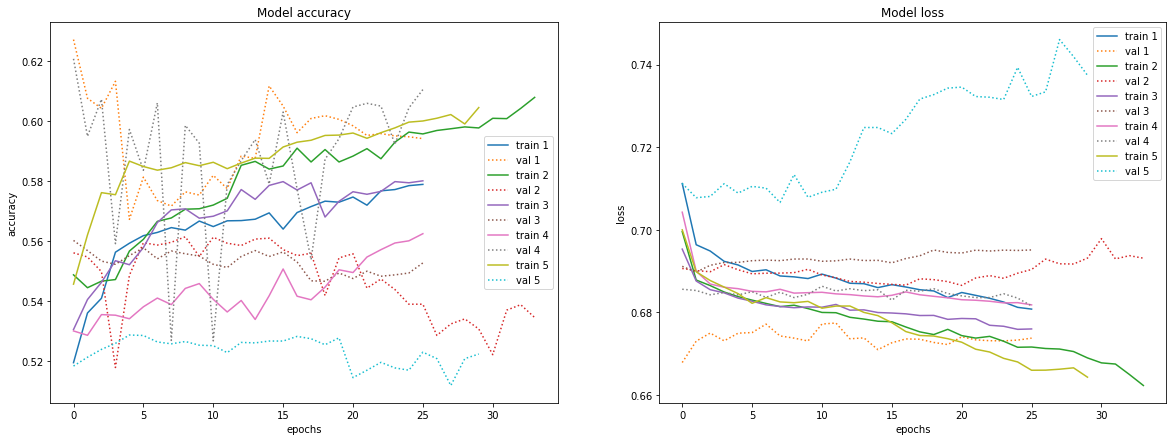

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax = ax.ravel()

for fold in history:
    for i, metric in enumerate(["accuracy","loss"]):
        ax[i].plot(history[fold].history[metric], label="train "+str(fold))
        ax[i].plot(history[fold].history["val_" + metric], linestyle="dotted", label="val "+str(fold))
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend()

In [20]:
kfold_results = pd.DataFrame(columns=["Fold","Mean_Loss","Mean_Accuracy"])
key = []
mean_loss = []
mean_acc = []
for fold in history:
    key.append(fold), 
    mean_loss.append(np.mean(history[fold].history["val_loss"]))
    mean_acc.append(np.mean(history[fold].history["val_accuracy"]))

kfold_results["Fold"] = key
kfold_results["Mean_Loss"] = mean_loss
kfold_results["Mean_Accuracy"] = mean_acc
kfold_results["Rank_Ratio"] = (kfold_results["Mean_Loss"] - kfold_results["Mean_Accuracy"])
kfold_results = kfold_results.sort_values("Rank_Ratio", ascending=True)
kfold_results

,Fold,Mean_Loss,Mean_Accuracy,Rank_Ratio
0,1,0.673649,0.593237,0.080412
3,4,0.684512,0.588153,0.096359
2,3,0.693081,0.552896,0.140184
1,2,0.689856,0.547429,0.142427
4,5,0.722986,0.523175,0.199812


In [21]:
best_kfold_model = './Brain_lstm_kfold_' + str(kfold_results.Fold.values[0]) + '.h5'
print(f"The best select model is {best_kfold_model}")

The best select model is ./Brain_lstm_kfold_1.h5


# <span style="color:#0b0a2d; font-size:24px; text-transform: uppercase; font-weight:bold" id="section_6">Predict on test set with best model</span>

We will now create the ResNet50 matrices for the test set and make the predictions on the test patients.

In [22]:
X_test = test['BraTS21ID5'].values
test_listMatrix = []
for i, patient in enumerate(tqdm(X_test)):
    test_listVectors = []
    test_sequence = load_dicom_images_3d(scan_id=str(patient),mri_type=MRI_TYPE,split="test")
    for j in range(len(test_sequence)):
        img = test_sequence[j]
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.resnet50.preprocess_input(img)
        img_vector = base_resnet.predict(img)
        test_listVectors.append(np.array(img_vector))
    
    test_PatientMatrix = np.stack(test_listVectors)
    test_listMatrix.append(test_PatientMatrix)

  0%|          | 0/76 [00:00<?, ?it/s]

In [23]:
print(f"Number of test patient matrix: {len(test_listMatrix)}")
print(f"Test patient matrix shape: {test_listMatrix[0].shape}")

Number of test patient matrix: 76
Test patient matrix shape: (64, 1, 2048)


In [24]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_listMatrix)
len(test_dataset)

76

In [25]:
final_model = keras.models.load_model(best_kfold_model)
predict = final_model.predict(test_dataset)
print(predict.shape)

(4864, 1, 1)


In [26]:
predict = predict[:,0,0]
final_predict = []
for i in range(len(test_listMatrix)):
    i+=1
    final_predict.append(round(predict[((i-1)*NUM_IMAGES):(NUM_IMAGES*i)].mean(),3))
submission = test[["BraTS21ID","MGMT_value"]]
submission["MGMT_value"] = final_predict
submission.to_csv('TT_Model3_ResNet.csv',index=False)
submission.head(5)

<ipython-input-26-bb2b2956ad84>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission["MGMT_value"] = final_predict


,BraTS21ID,MGMT_value
0,17,0.571
1,20,0.571
2,28,0.571
3,53,0.566
4,87,0.571


In [2]:
plt.figure(figsize=(8, 8))
plt.hist(submission["MGMT_value"])
plt.title("Predicted probabilites distribution on test set", 
          fontsize=18, color="#0b0a2d")
plt.show()

NameError: name 'plt' is not defined

<span style="color:red; font-size:18px">Don't forget to **upvote** if this Notebook helped you!</span>